<a href="https://colab.research.google.com/github/Lindakk/Tesla_stock_time_series_forcasting/blob/main/Tsla_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving TSLA.csv to TSLA.csv


In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import minmax_scale
import numpy as np
from tensorflow.keras import layers
import os

df=pd.read_csv('TSLA.csv')


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


(2359, 2359, 294, 294, 296, 296)

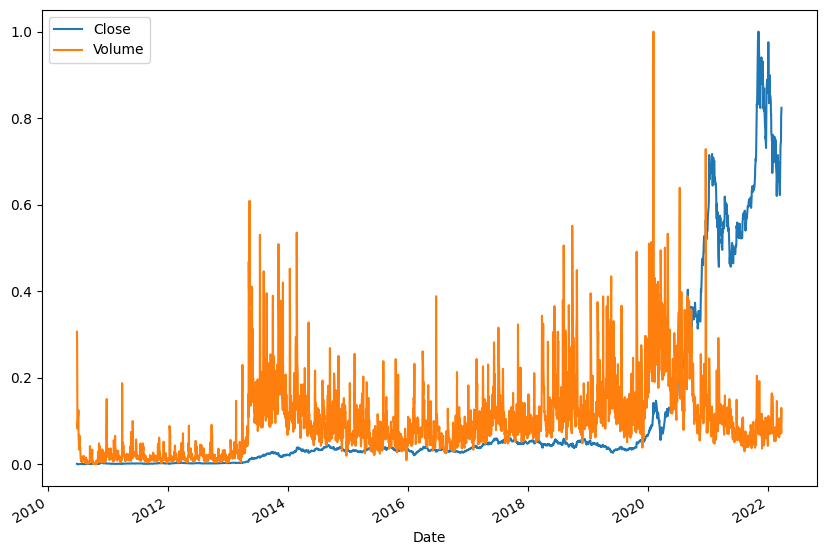

In [ ]:

df['Date']=pd.to_datetime(df['Date'])
df=df.set_index(df.Date)

#check if there is nulls
df.isna().any()

prices_nbeats = df[['Close','Volume']]

# plt these two columns


scaled_price_df = pd.DataFrame(minmax_scale(prices_nbeats[['Close', 'Volume']]), # we need to scale the data first
                                     columns=prices_nbeats.columns,
                                     index=prices_nbeats.index)
scaled_price_df.plot(figsize=(10, 7));

#making windows
WINDOW_SIZE=7
HORIZON=1
prices_windowed =scaled_price_df.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  prices_windowed[f"Price+{i+1}"] = prices_windowed["Close"].shift(periods=i+1)

X = prices_windowed.dropna().drop("Close", axis=1).astype(np.float32)
y = prices_windowed.dropna()["Close"].astype(np.float32)

# Make train and test sets
num_samples = len(X)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

# Split the data into training, validation, and test sets
X_train, y_train = X[:train_size],y[:train_size]
X_val,y_val = X[train_size:train_size + val_size],y[train_size:train_size + val_size]
X_test,y_test = X[train_size + val_size:], y[train_size + val_size:]


len(X_train), len(y_train), len(X_val),len(y_val),len(X_test), len(y_test)



In [ ]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Make multivariate time series model
tf.random.set_seed(42)

# LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE+1))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)

x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=output, name="model_1_lstm")

# Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
History_1=model_1.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_val, y_val),
            callbacks=[create_model_checkpoint(model_name=model_1.name),early_stopping])

In [ ]:
preds_1=model_1.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [ ]:
#Plotting the prediction intervals for the ensemble model

def get_upper_lower(preds): # 1. Take the predictions

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds

  lower, upper = preds - interval, preds + interval
  return lower, upper



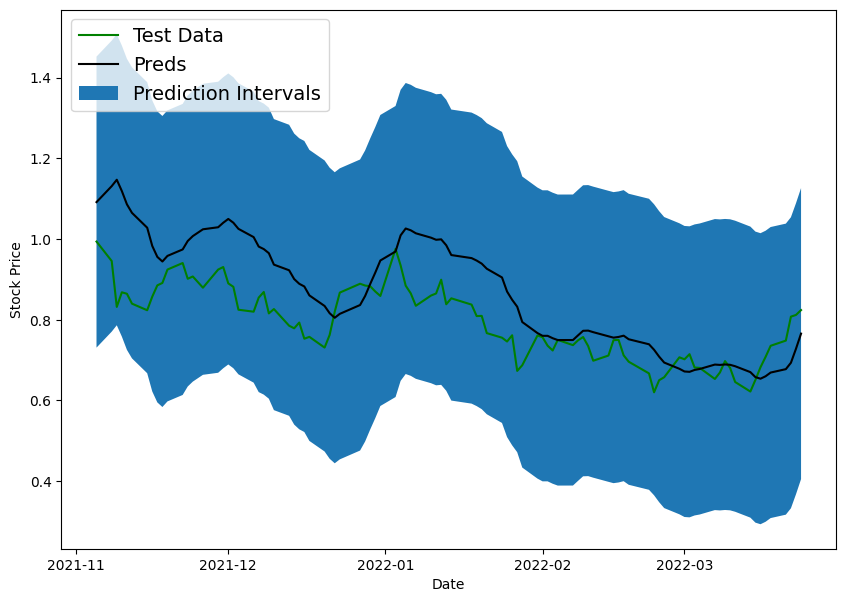

In [ ]:
# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=preds_1)

# Plot the preds along with the prediction intervals (where the predictions fall between)
offset=100
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], preds_1[offset:], "k-", label="Preds")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.fill_between( X_test.index[offset:],
                 tf.squeeze((lower)[offset:]),
                 tf.squeeze((upper)[offset:]), label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);


In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),input_shape=(WINDOW_SIZE+1,)),
    tf.keras.layers.GRU(units=64, input_shape=(WINDOW_SIZE, WINDOW_SIZE+1)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(HORIZON) ])

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
History_2=model_2.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_val, y_val),
            callbacks=[create_model_checkpoint(model_name=model_2.name),early_stopping])


In [ ]:
model_2.evaluate(X_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.1578


0.15780887007713318

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=X_train,
                        val_data=X_val,
                        num_iter=5,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:


      # Construct a model architecture
      model = tf.keras.Sequential([

        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(X_train,y_train,
                epochs=num_epochs,
                verbose=0,
                validation_data=(X_val,y_val),
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models



ensemble_models = get_ensemble_models()

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=X_val)
ensemble_preds

# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_val,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

In [ ]:
#Plotting the prediction intervals for the ensemble model
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_val.index[offset:], y_val[offset:], "g", label="Test Data")
plt.plot(X_val.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.fill_between(X_val.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);